In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
from galpy import potential,df
from galpy.orbit import Orbit
from astropy import units as u

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

# Scripts
from AxionStreams import plot as pl
from AxionStreams import orbit as orb
from AxionStreams import density as dens

# Set units

kpc = u.kpc
kms = u.km/u.s
deg = u.deg
Gyr = u.Gyr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Orbit creation from sampling 

In [2]:
N_samples = 1000
nframes   = 1000
T_Gyr     = 10
ts        = np.linspace(0.0,T_Gyr*u.Gyr,nframes)

In [3]:
samples  = orb.orbit_sampling(N_samples)

In [4]:
%%time
Orbits   = orb.orbit_coordinates(samples,T_Gyr,nframes,ctype='Cartesian')

# Timeframe, coordinate, sample number 
# Coords[0,:,0]

CPU times: user 38.9 s, sys: 186 ms, total: 39.1 s
Wall time: 40.1 s


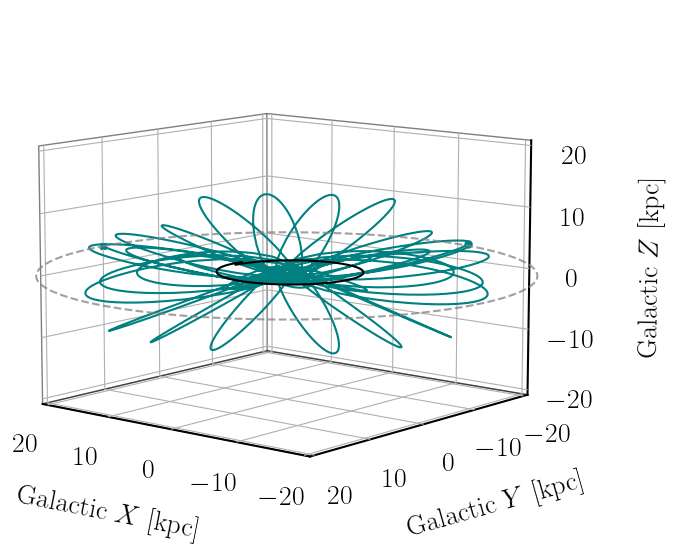

In [7]:
orbit_num = 5
pl.plot_single_orbit(Orbits[:,:,orbit_num],azim=10,sun=True,disk=True,lim=20,points=False,size_x=7,size_y=7)

In [8]:
# Count disk encouters

help(orb.disk_encounters)
# Testing 

np.testing.assert_array_equal(orb.disk_encounters(Orbits,maxrad=0),orb.disk_encounters(Orbits))

# Example

# enc = disk_encounters(Orbits)
# enc[:20]

Help on function disk_encounters in module AxionStreams.orbit:

disk_encounters(orbits, maxrad=0)
    Computes the number of disk encounters (crossing z=0) for each orbit, discards encounters with radii larger 
    than maxrad
    Input: 
        - Orbits coordinates from orbit_coordinates function with shape (nframes,3,nsamples)
        - Maximum radius to consider the disk encounter in kpc
    Output:
        - List with number of encounters for each orbit, shape (nsamples)



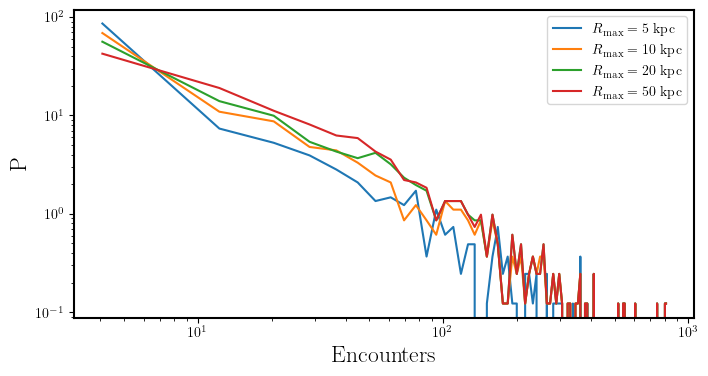

In [9]:
fig,ax = plt.subplots(figsize=(8,4))

for rad in [5,10,20,50]:
    enc = orb.disk_encounters(Orbits,maxrad=rad)
    enc_max = np.max(enc)
    dP, rb = np.histogram(enc,bins=100,range=[0,enc_max])
    rc = (rb[0:-1]+rb[1:])/2
    dr = rb[1]-rb[0]
    rho = (1/(4*np.pi*rc**2))*(dP/dr)
    rho = dP/dr
    ax.loglog(rc,rho,label=r'$R_{\rm max}=%d~{\rm kpc}$'%rad)
ax.set_xlabel('Encounters',fontsize=17)
ax.set_ylabel('P',fontsize=17)
ax.legend()
plt.show()

In [31]:
# Check now the stellar density 

help(dens.stellar_density)

Help on function stellar_density in module AxionStreams.density:

stellar_density(x, y, z)
    Returns the full stellar density as a function of cartesian coords.
    Units are kpc for input and SolarMasses/pc^3 for output



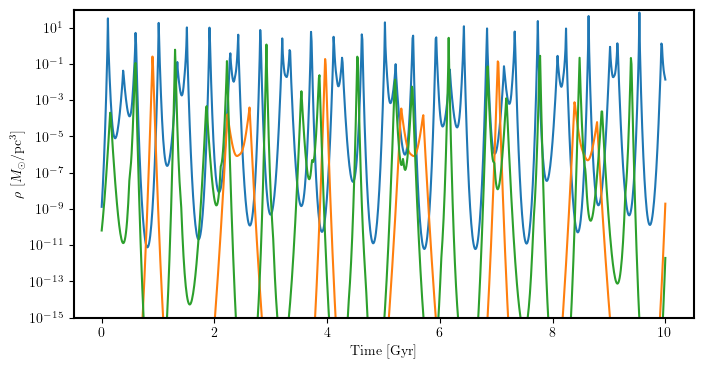

In [30]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

for j in [10,20,30]: # Some random orbits
    rho_test  = dens.stellar_density(Orbits[:,0,j],Orbits[:,1,j],Orbits[:,2,j])
    ax.semilogy(ts,rho_test)
ax.set_ylim(1e-15,1e2)
ax.set_xlabel('Time~[Gyr]')
ax.set_ylabel(r'$\rho~[M_{\odot}/{\rm pc}^3]$')
plt.show()

## Density profiles from samples 

In [166]:
help(orb.get_profile)

Help on function get_profile in module AxionStreams.orbit:

get_profile(nsamples, rmax=10000, ro=8)
    Reproduces the density profile from the sampled miniclusters
    
    Use: r,rho = get_profile(nsamples,rmax=10000,ro=8)
    
    Input: 
        - nsamples: the sample array
        - rmax: maximum radius in kpc  
        - ro: scale radius in kpc
    
    Output: 
       - r: radial coordinates in kpc
       - rho: density profiles in a.u.



In [170]:
def NFW(r,r_s=19.4):
    #rho_s = 0.43 # SolarMass/pc^3
    rho_s = 1
    return 1/(r/r_s*(1+r/r_s)**2)

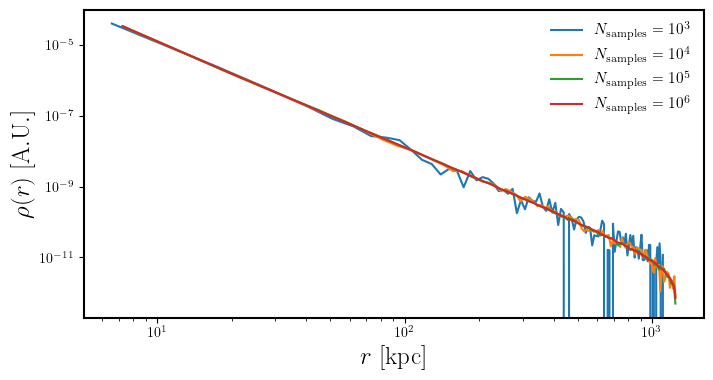

In [168]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
for i in [1e3,1e4,1e5,1e6]:
    r, rho = orb.get_profile(i)
    ax.loglog(r,rho/i,label=r'$N_{\rm samples}=10^{%d}$'%np.log10(i))
ax.set_xlabel(r'$r~[{\rm kpc}]$',fontsize=18)
ax.set_ylabel(r'$\rho(r)~[{\rm A.U.}]$',fontsize=18)
ax.legend(frameon=False,fontsize=11)
plt.show()

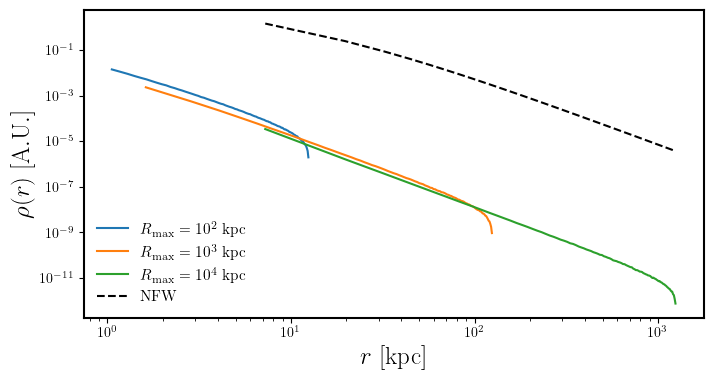

In [163]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
for rm in [100,1000,10000]: 
    r, rho = orb.get_profile(1e6,rmax=rm)
    ax.loglog(r,rho/i,label=r'$R_{\rm max}=10^{%d}~{\rm kpc}$'%np.log10(rm))
ax.loglog(r,NFW(r),c='k',ls='--',label='NFW')
ax.set_xlabel(r'$r~[{\rm kpc}]$',fontsize=18)
ax.set_ylabel(r'$\rho(r)~[{\rm A.U.}]$',fontsize=18)
ax.legend(frameon=False,fontsize=11)
plt.show()

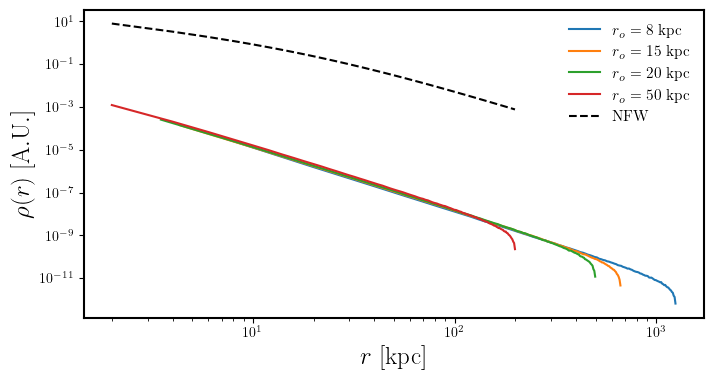

In [164]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
for ro in [8,15,20,50]: 
    r, rho = orb.get_profile(1e6,ro=ro)
    ax.loglog(r,rho/i,label=r'$r_o=%d~{\rm kpc}$'%(ro))
ax.loglog(r,NFW(r),c='k',ls='--',label='NFW')
ax.set_xlabel(r'$r~[{\rm kpc}]$',fontsize=18)
ax.set_ylabel(r'$\rho(r)~[{\rm A.U.}]$',fontsize=18)
ax.legend(frameon=False,fontsize=11)
plt.show()

In [169]:
# Save samples to txt/csv file 
# Initialisation of orbits from samples only 

# N_samples = int(1e6)

# pot  = potential.NFWPotential()
# distr_funct = df.isotropicNFWdf(pot=pot,rmax=10000*kpc,ro=8*kpc)#,rmax=200*kpc,vo=230*kms)#,ro=5*kpc)
# samples = distr_funct.sample(n=N_samples,return_orbit=False)
# R_i = samples[0]

In [171]:
# fig,ax = plt.subplots(1,1,figsize=(8,4))
# ax.loglog(rc,NFW(rc))
# ax.loglog(rc,rho)
# plt.show()

In [25]:
## Some attributes/methods of orbit class 
## samples can be replaced by any 'orbit' object

# Coordinates

# samples.r() # Spherical radius at time t
# samples.R() # Cylindrical radius at time t
# samples.theta()
# samples.x()
# samples.y()
# samples.z()

# # Velocities 

# samples.vx()
# samples.vy()
# samples.vz()
# samples.vphi() # Angular velocity

# # Time
# samples.time()

# Periods (needs to be integrated first)

# samples.Tr()
# samples.Tp()

#samples.dim()  # dimensions
#samples.dist() # return distance from the observer in kpc

# Integration 

# samples.integrate(t, pot, method='symplec4_c', progressbar=True, dt=None, numcores=2, force_map=False)

In [ ]:
# np= potential.NFWPotential(amp=1.2,a=2.3)
# #sam = sphericaldf.sample(R=None, z=None, phi=None, n=1, return_orbit=True, rmin=0.0)
# ndf= isotropicNFWdf(pot=np)
# # sample
# sam= ndf.sample(n=100)
# print(numpy.std(sam[numpy.fabs(sam.r()-1.2) < 0.1].vr()))
# # 0.2156787374302913
# # Compute vel. dispersion
# #print(ndf.sigmar(1.2))

In [ ]:
# from galpy.orbit import Orbit
# from galpy.potential import MWPotential2014
# import numpy
# import astropy.units as u
# ts= numpy.linspace(0.,1.,1001)*u.Gyr
# o = Orbit() 
# o.integrate(ts,MWPotential2014)
# o.plot()